In [3]:
# importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import glob
import pickle

"""
Step 1: Camera Calibration

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

"""
def calibrate_camera(images, nx=9, ny=6):
    """"
    images = paths to the images used to calibrate the camera
    nx = Number of inside corners in x
    ny = Number of inside corners in y
    """

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    img = None
    for fname in images:    
        img = cv2.imread(fname)
        
        # convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #BGR as we are using glob API

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            imgpoints.append(corners) # if distorted image has corners they will be appended here
            objpoints.append(objp) # these points will be the same for all of the calibration images, since they are from a real chessboard 

            # draw and display the corners
            img_d = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
            file_name = './output_images/' + fname[13:]
            
            #save them to the test_images_output directory.
            cv2.imwrite(file_name, img_d)
               
            
        # Camera calibration, given object points, image points, and the shape of the grayscale image,
        # returns distortion coefficients (dist) camera matrix (mtx), camera position in the world, rotation (rvecs), translation (tvecs)
       
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
        dist_pickle = {}
        dist_pickle['mtx'] = mtx
        dist_pickle['dist'] = dist
        
    return ret, mtx, dist, rvecs, tvecs, img
       
# Make a list of calibration images

image = glob.glob('./camera_cal/calibration*.jpg')

ret, mtx, dist, rvecs, tvecs, img = calibrate_camera(image)

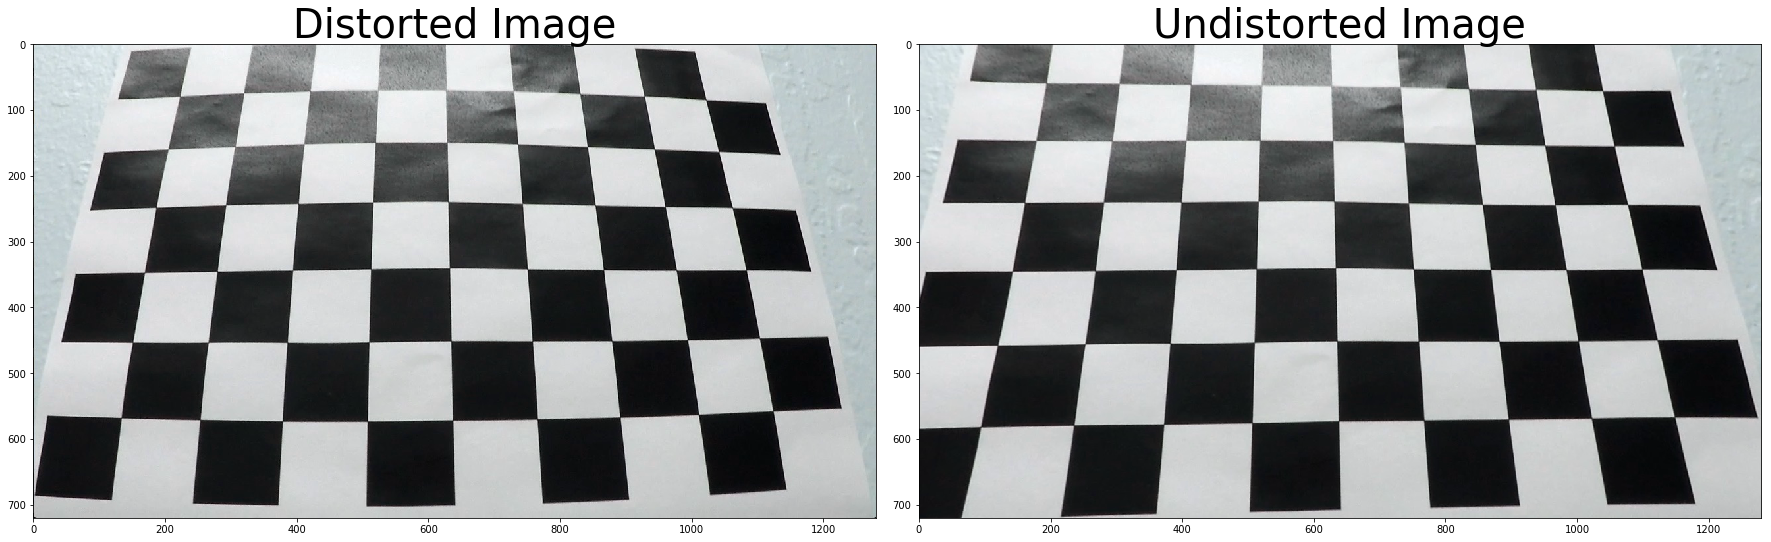

In [85]:
"""
Step 2: Apply a distortion correction to raw images.

Distortion can change the apparent size of an object in an image
Distortion can change the apparent shape of an object in an image
Distortation can cause an objects appearance to change depending on where it is in the field of view
Distortion and make objects appear closer or father away than they actually are.

"""
img = cv2.imread('./camera_cal/calibration3.jpg')


undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Distorted Image', fontsize=40)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

(1280, 720)


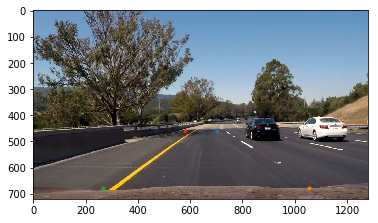

In [5]:
BGR_img = cv2.imread("test_images/test6.jpg")

#Convert cv2 back to RGB after reading in
img = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB) 

img_size = (img.shape[1], img.shape[0]) # width x height

plt.imshow(img)
plt.plot(701,459, '.') #top right
plt.plot(1055,680,'.') #bottom right
plt.plot(265,680,'.') #bottom left
plt.plot(580,459,'.') #top left

print(img_size)


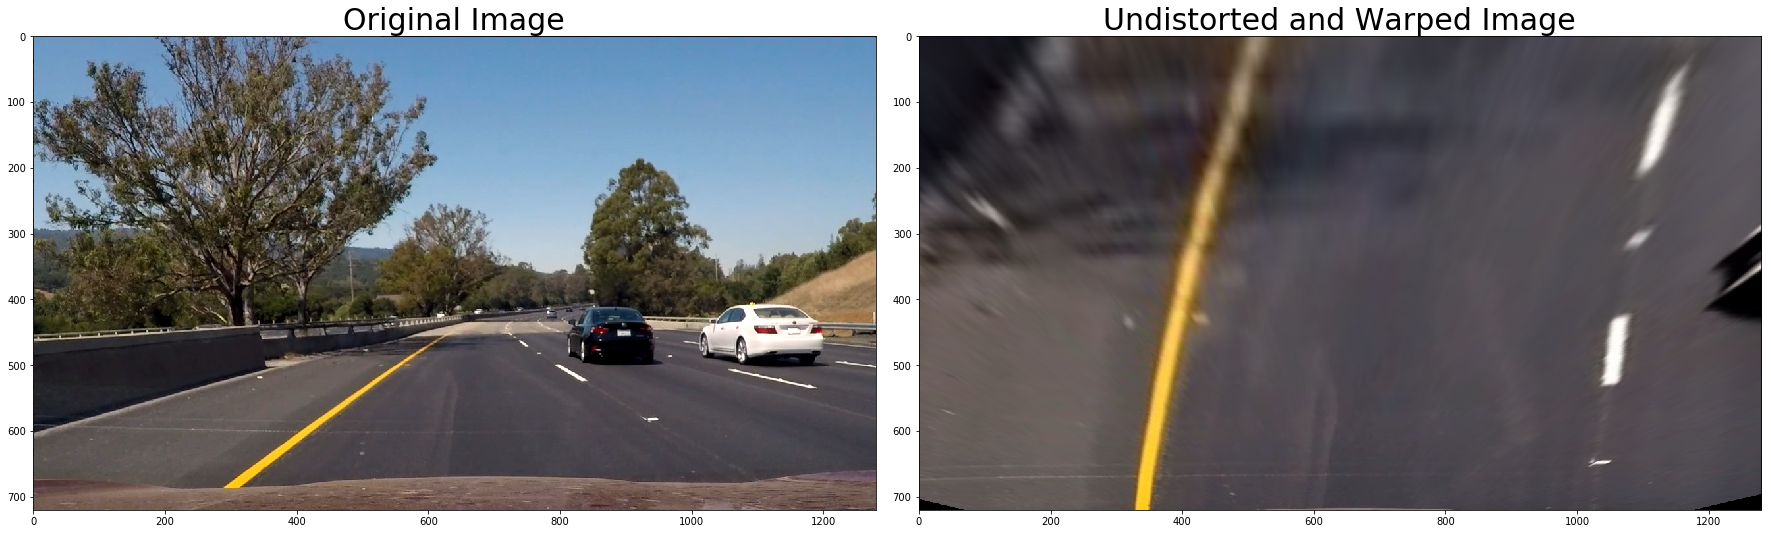

In [6]:
"""Step 3: Apply a Perspective Transform

Transforming an image such that we are effectively viewing objects from a different angle or direction
Objects appear smaller the farther away they are from a viewpoint, like a camera, parallel lanes appear to converge 
to a point.  We are interested in a perspective transform as we want to ultimately measure the curvature of a lane line.
To accomplish this we need to transform a top-down view.
"""

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def warp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    
    # Undistort using mtx and dist
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
    img_size = (gray.shape[1], gray.shape[0]) # width x height
    offset = 300 # pixels
    
    # pixel values for 4 source points determined by yangchat.github.io/iview/iview.html
    src = np.float32([(701,459), #top right
                     (1055,680), #bottom right
                      (265,680),#bottom left
                     (580,459)])#top left
    
    
    # point array dst - destintation points close to source points in a rectangle
    
    dst = np.float32([(img_size[0]-offset,0), #top right
                       (img_size[0]-offset,img_size[1]), #bottom right
                       (img_size[0]-img_size[0]+offset,img_size[1]),#bottom left
                     (img_size[0]-img_size[0]+offset,0)])#top left
        
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # use.cv2.getPerspectiveTransform() to get Minv, the inverse transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undist, M, img_size)

    return warped, M, Minv

warped, M, Minv = warp(img, nx, ny, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

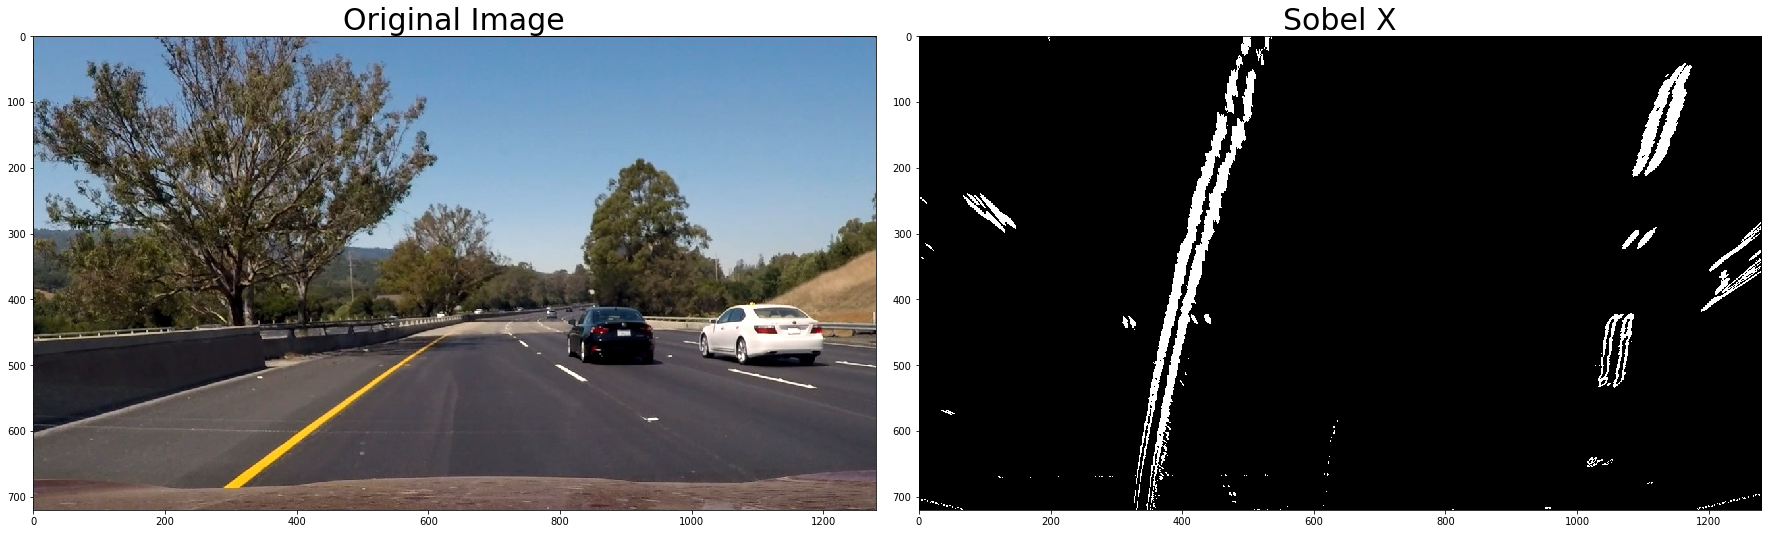

In [7]:
""" Step 4a: Sobel Operator Threshold

The Sobel operator is at the heart of the Canny edge detection algorithim.  Applying the Sobel operator to an image is
a way of taking the derivative of theimage in the x or y direction.  

"""

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):

    # pass a single colour channel to the cv2.sobel() function, convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    
    #calculate deritive in x-direction (1,0) at the end denotes x direction
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    #calculate deritive in y-direction (0,1) at the end denotes y direction
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    #convert the ximage to 8-bit, useful when we apply a threshold
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    #create a binary threshold to select pixels based on gradient strength
    
    thresh_min = 20
    thresh_max = 100
    sbinary = np.zeros_like(scaled_sobel)
    #threshold range of gradient strength between 0 and 1
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #plt.imshow(sbinary, cmap='gray')
    return sbinary
    
gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255)
    
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Sobel X', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

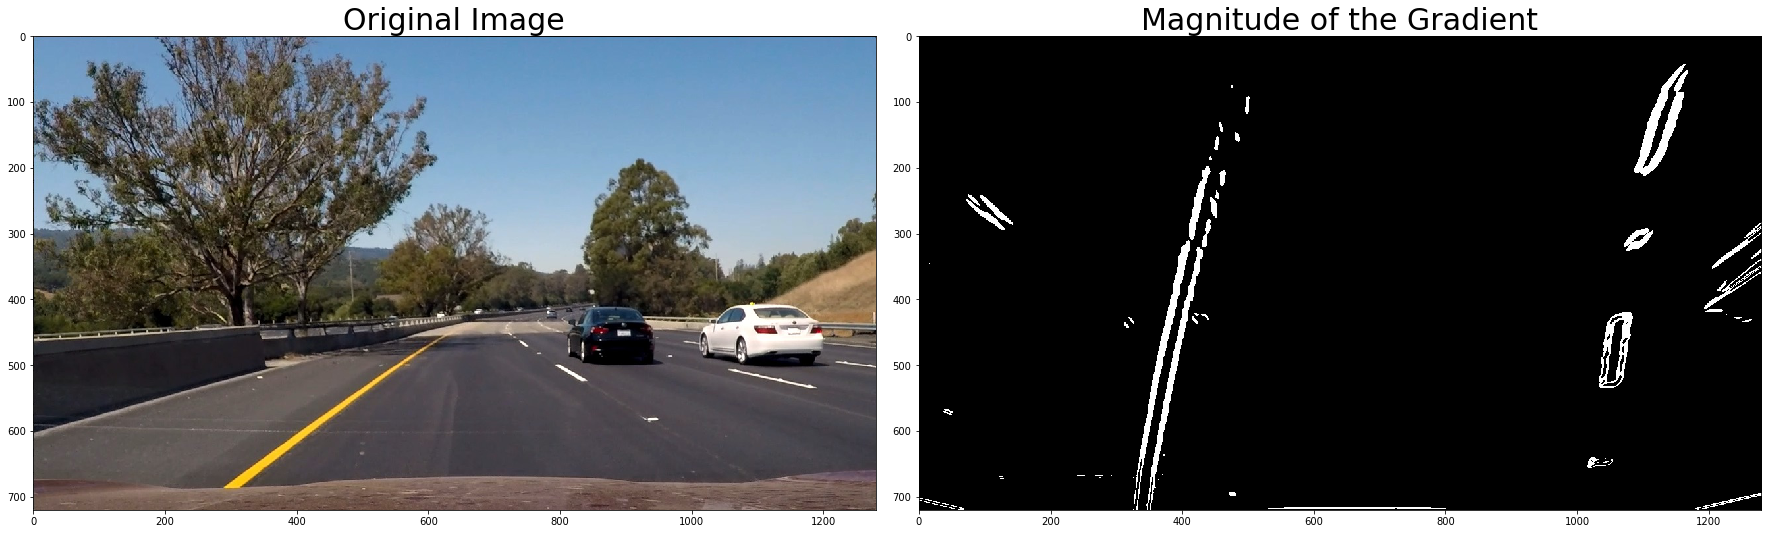

In [8]:
""" Step 4b. Magnitude of the Gradient
Apply a threshold to the overall magnitude of the gradient, in both x and y direction.
"""

def mag_thresh(img, sobel_kernel=9, mag_thresh=(0, 255)):
    
    #convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    
    # calulate the derivative in the x and y direction using Sobel operator
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    #rescale to 8-bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output
    
# Run the function
mag_binary = mag_thresh(warped, sobel_kernel=9, mag_thresh=(30, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Magnitude of the Gradient', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

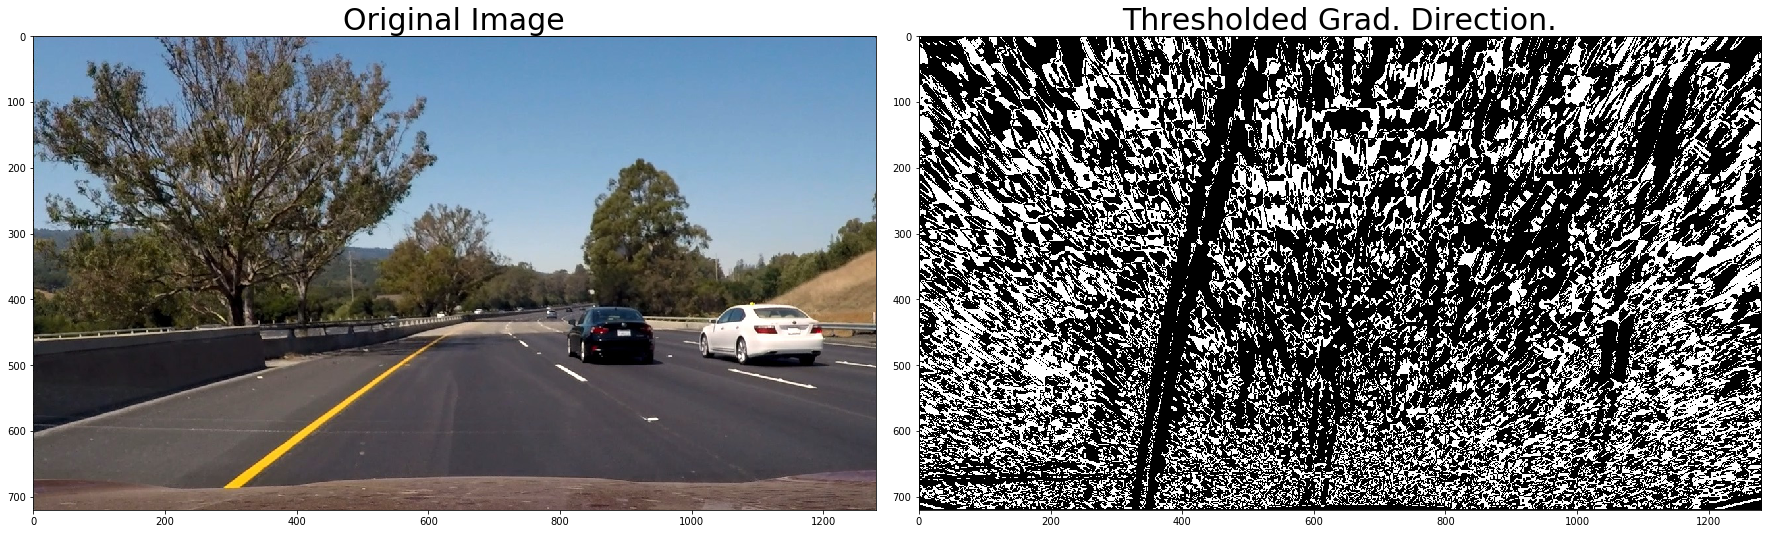

In [9]:
""" Step 4c. Direction of the Gradient
When looking at lane lines, knowing the direction of the gradient can be useful, as we know lane lines we are interested
are of a particular orientation.  We can determine the direction, or orientation, of the gradient.

Each pixel of the resulting image contains a value for the angle of the gradient away from horizontal in units of radians, 
covering a range of −π/2 to π/2. An orientation of 0 implies a vertical line and orientations of +/− π/2 imply horizontal 
lines.

The direction of the gradient is simply the inverse tangent (arctan) of the y gradient divided by the x gradient,
arctan(sobely/sobelx).
"""


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Run the function
dir_binary = dir_threshold(warped, sobel_kernel=15, thresh=(0.7, 1.3))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Direction.', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

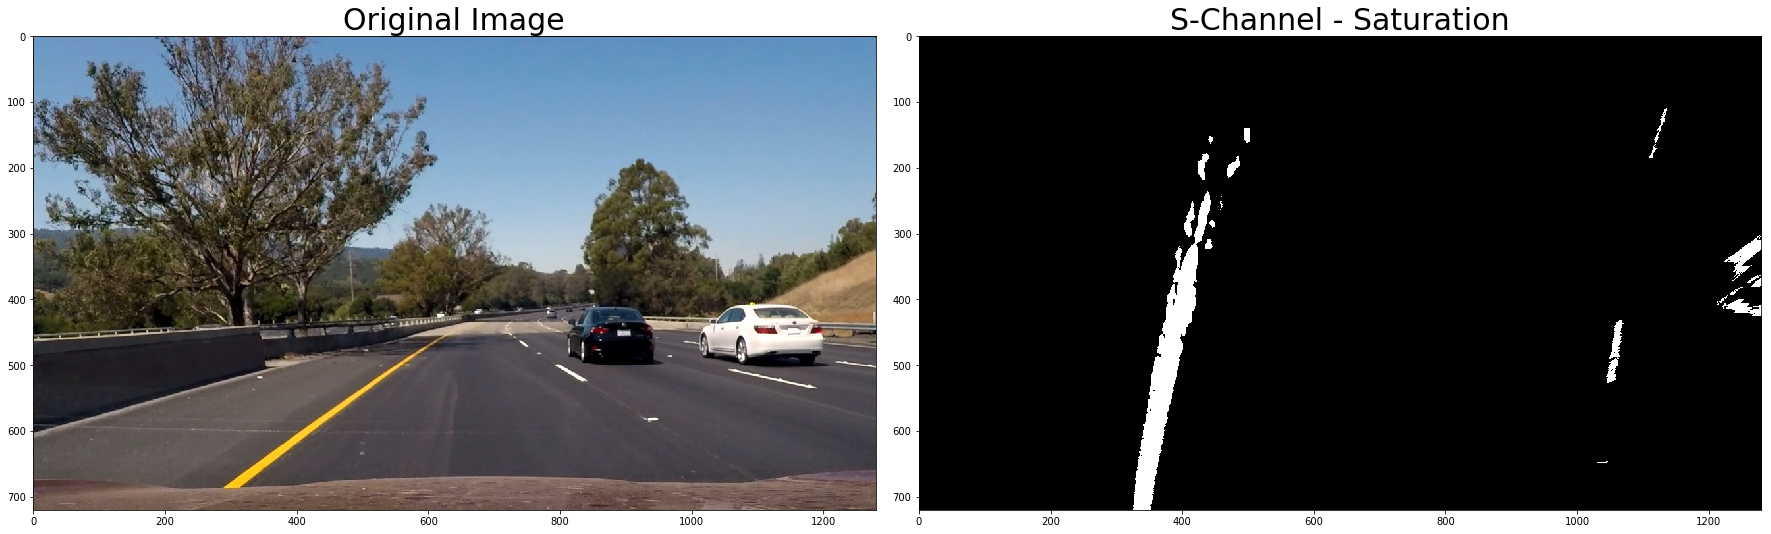

In [10]:
""" Step 5: Color Thresholding 

RGB is red-green-blue color space, where any color can be represented by a 3D coordinate of R, G and B values.
For example, white has the coordinate (255,255,255), which has the maximum value for red, green, and blue.

HSV is hue-saturation-value colorspace and HLS is hue, lightness and saturation.  Which we will utilize in our function.

Hue is a value that represents color independent of any change in brightness.

Lightness and Value represent different ways to measure the relative lightness or darkness of a color.

Saturation is a measurement of colorfulness, i.e. as a colors get lighter and closer to white, they have a lower saturation value.

"""

def hls_select(img, thresh=(0, 255)):
    #convert to hls colorspace
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) #RGB as we are using CV2
    
    #Isolate for saturation channel as its best at identifying lane lines in most scenarios (shadows)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    binary_output = np.zeros_like(s_channel)
    # apply thresholds to isolate lane lines
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary_output

hls_binary = hls_select(warped, thresh=(120,255))


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('S-Channel - Saturation', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

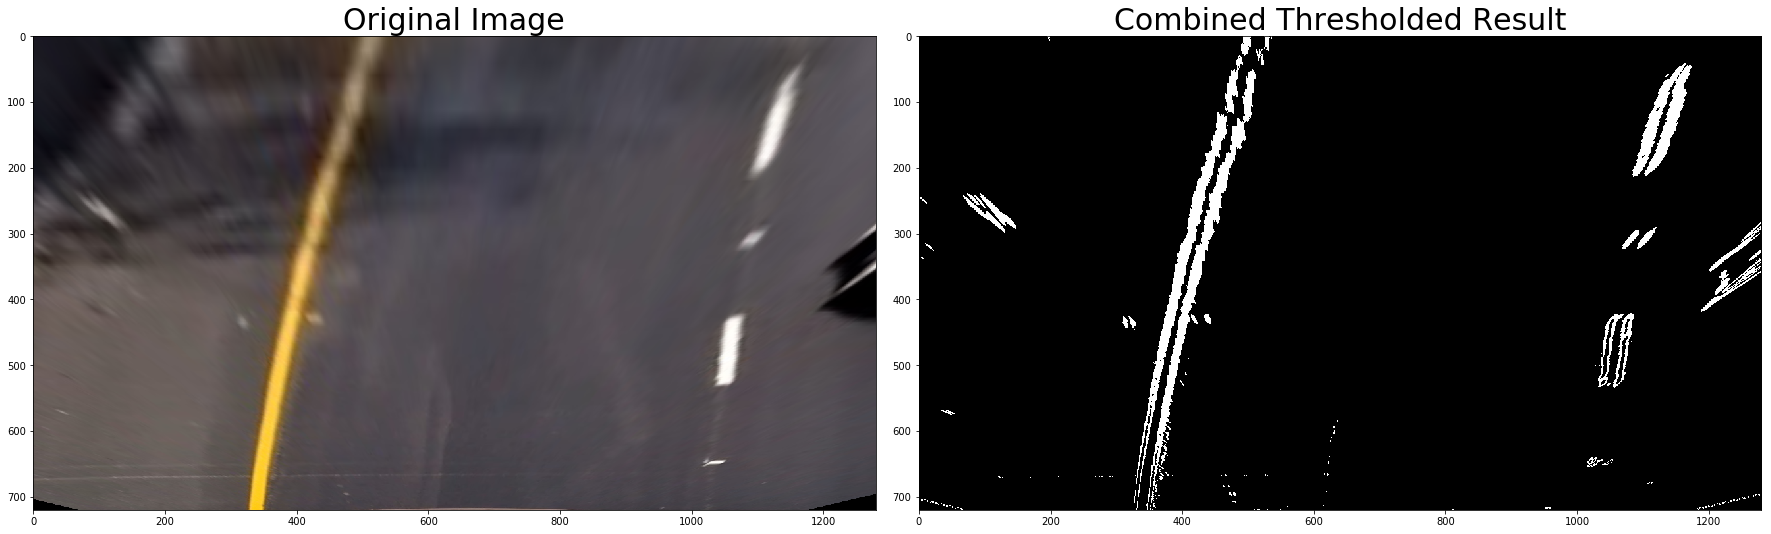

In [11]:
"""Step 6: Combine the results of each threshold function & HLS Colorspace"""

image = warped
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3)
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3)
mag_binary = mag_thresh(image, sobel_kernel=7, mag_thresh=(0, 255))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0, np.pi/2))

#Return a new array, filled with zeros.
combined = np.zeros_like(dir_binary)
combined[((gradx == 1)) | ((mag_binary == 0.5) & (dir_binary == 0.5))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Thresholded Result', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

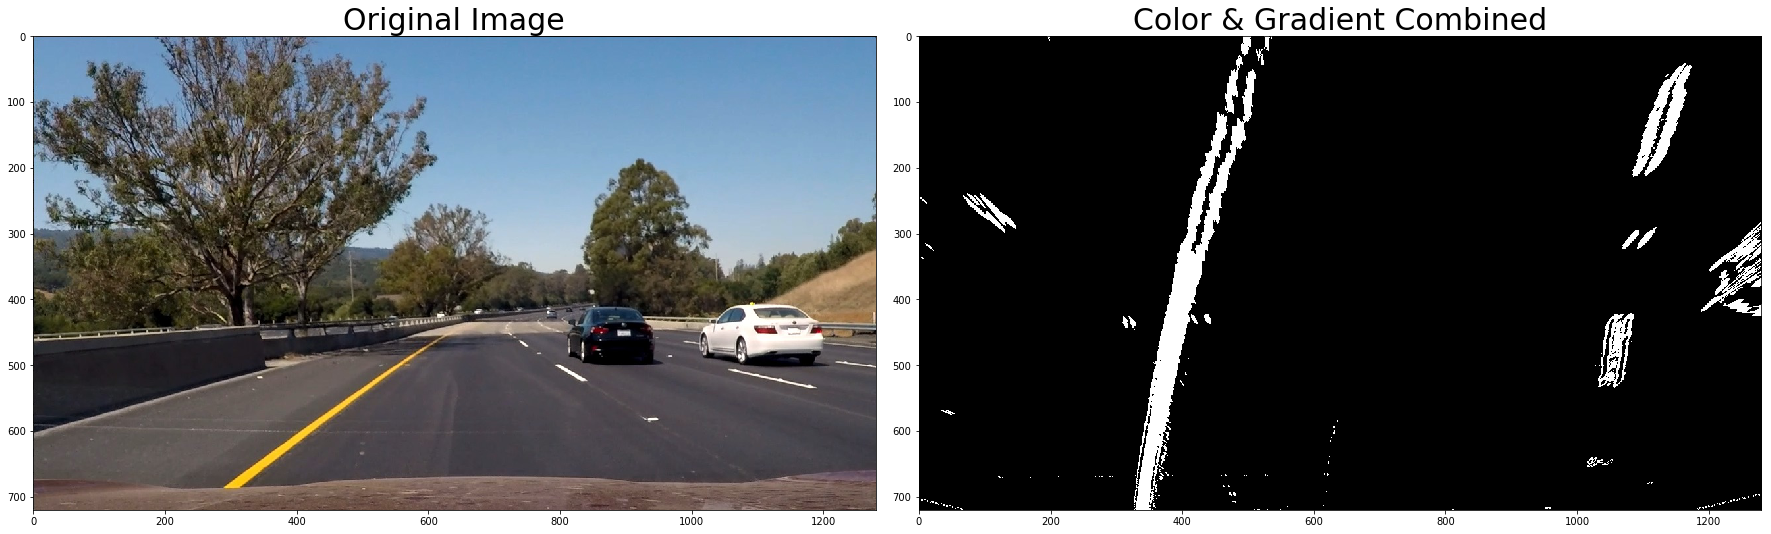

In [12]:
"""Step 7: Combine the Results of each Threshold Function & HLS Colorspace """

def color_and_gradient_threshold(img):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

    
combined_binary = color_and_gradient_threshold(warped)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Color & Gradient Combined', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

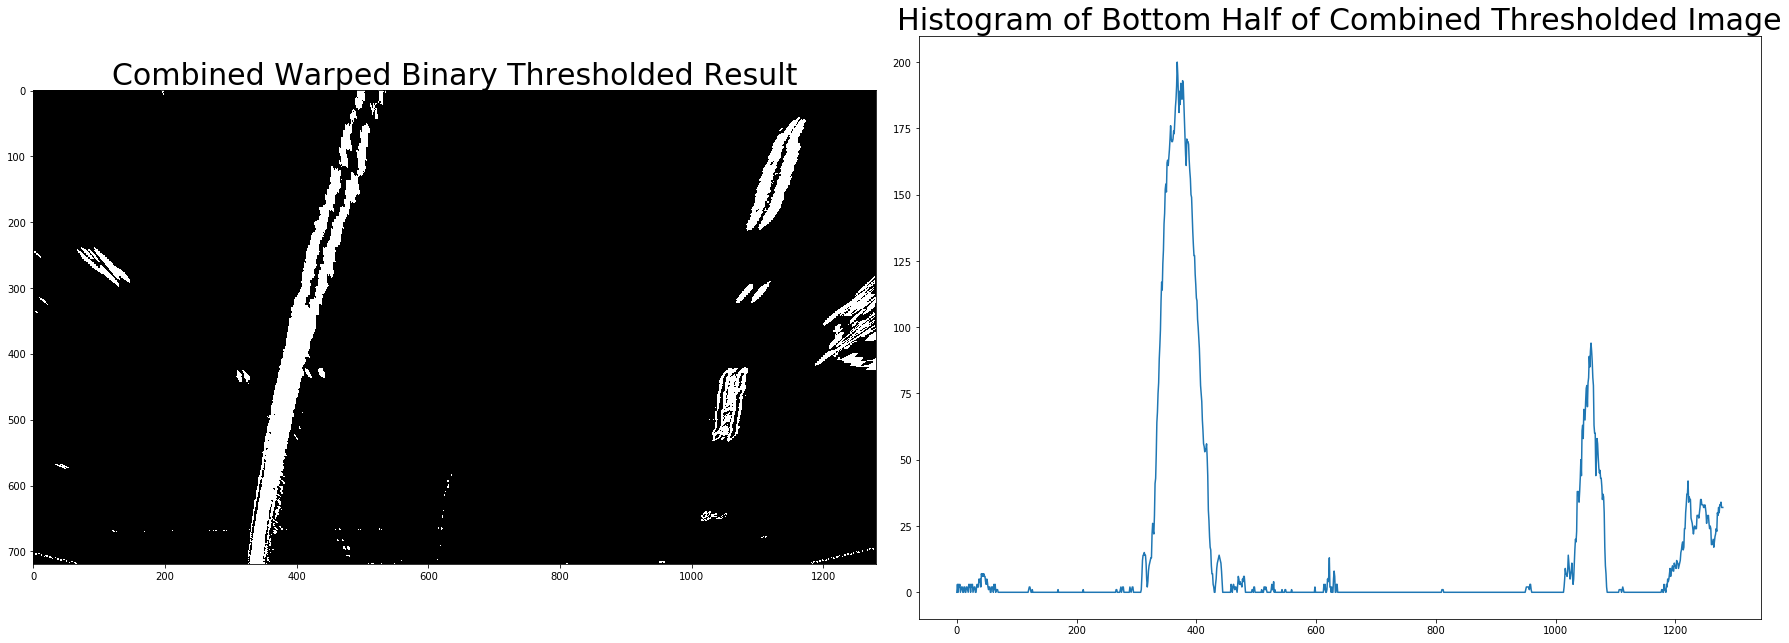

In [13]:
""" Step 8: Detect lane lines using a Histogram filter """

def hist(img):
    # Grab only the bottom half of the image
    bottom_half = img[img.shape[0]//2:,:]
    # Lane lines are likely to be mostly vertical nearest to the car

    # Sum across image pixels vertically - make sure to set `axis`
    histogram = np.sum(bottom_half, axis=0)
    # i.e. the highest areas of vertical lines should be larger values
    
    return histogram

# Create histogram of image binary activations
histogram = hist(combined_binary)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Combined Warped Binary Thresholded Result', fontsize=30)
plt.plot(histogram)
ax2.set_title('Histogram of Bottom Half of Combined Thresholded Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [65]:
def find_lane_line(binary_warped, return_img=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//3:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    out_img = (out_img*255).astype('uint8')
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//3)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    
    nwindows = 9 # Choose the number of sliding windows
    margin = 100 # Set the width of the windows +/- margin
    minpix = 50 # Set minimum number of pixels found to recenter window    
    window_height = np.int(binary_warped.shape[0]//nwindows) # Set height of windows - based on nwindows above and image shape

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    
    for window in range(nwindows): # Step through the windows one by one
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        #Find the four below boundaries of the window 
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 5) 
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
      

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [100, 200, 255]
    if return_img:
        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
 
    
    return out_img,left_fitx,right_fitx,ploty,left_fit,right_fit 
    # leftx and rightx is the predition from polynominal fit points
    # left_fit and right_fit are the coefficients


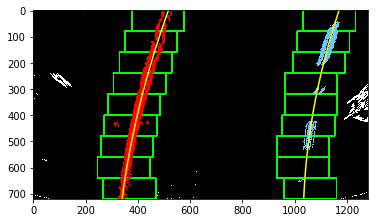

In [66]:
out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = find_lane_line(combined_binary, return_img=True)

plt.imshow(out_img)

In [67]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    
    # Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fit, right_fit, left_fitx, right_fitx

def search_around_poly(binary_warped, left_fit, right_fit, return_img=False):
    
    margin = 100 

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of our polynomial function 
    left_lane_inds = ((nonzerox > 
                       (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)
                      ) & (nonzerox < 
                           (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    ploty,left_fit, right_fit, left_fitx, right_fitx = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype('uint8')
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if return_img:
        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color = 'yellow')
        plt.plot(right_fitx, ploty, color = 'yellow')
        ## End visualization steps ##
    
    return result, ploty, left_fit, right_fit, left_fitx, right_fitx

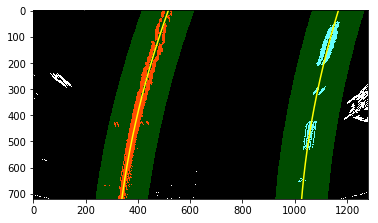

In [68]:
shaded_lanes, ploty, left_fit, right_fit, left_fitx, right_fitx = search_around_poly(combined_binary, left_fit, right_fit, return_img=True)

# View your output
plt.imshow(shaded_lanes)

In [69]:
# generate coefficient values for lane datapoints in meters
def generate_data(ploty, left_fitx, right_fitx, ym_per_pix, xm_per_pix):
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    return ploty*ym_per_pix, left_fit_cr, right_fit_cr

In [19]:
# calculate average radius of curvature of left and right lane lines
# and calculate centre offset of vehicle within lane assuming camera is mounted directly in the middle centreline of vehicle

def measure_curvature_real(ploty, left_fitx, right_fitx):
    '''
    Calculates the curvature of two polynomial lane lines in meters from pixel space.
    '''
    # define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    lane_centre = (left_fitx[-1] + right_fitx[-1])/2
    centre_offset_pixels = img_size[0]/2 - lane_centre
    # convert to metres from pixels using conversion
    centre_offset_metres = xm_per_pix*centre_offset_pixels
    
    # generate data points for left and right curverad
    ploty, left_fit_cr, right_fit_cr = generate_data(ploty, left_fitx, right_fitx, ym_per_pix, xm_per_pix)
    
    # define y-value where we want radius of curvature from the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5)//(2*abs(left_fit_cr[0]))  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5)//(2*abs(right_fit_cr[0]))  ## Implement the calculation of the right line here
    average_curvature = (left_curverad + right_curverad)/2
    
    return average_curvature, centre_offset_metres, left_curverad, right_curverad

In [20]:
average_curvature, centre_offset_metres, left_curverad, right_curverad = measure_curvature_real(ploty, left_fitx, right_fitx)
print("Average Curvature: " + str(average_curvature) + " m")
print("Vehicle Offset from Centre of Lane: " + str(centre_offset_metres) + " m")

Average Curvature: 1057.5 m
Vehicle Offset from Centre of Lane: -0.225845822732 m


In [71]:
def draw_shade(img, warped, left_fit, right_fit, ploty, Minv):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    return newwarp


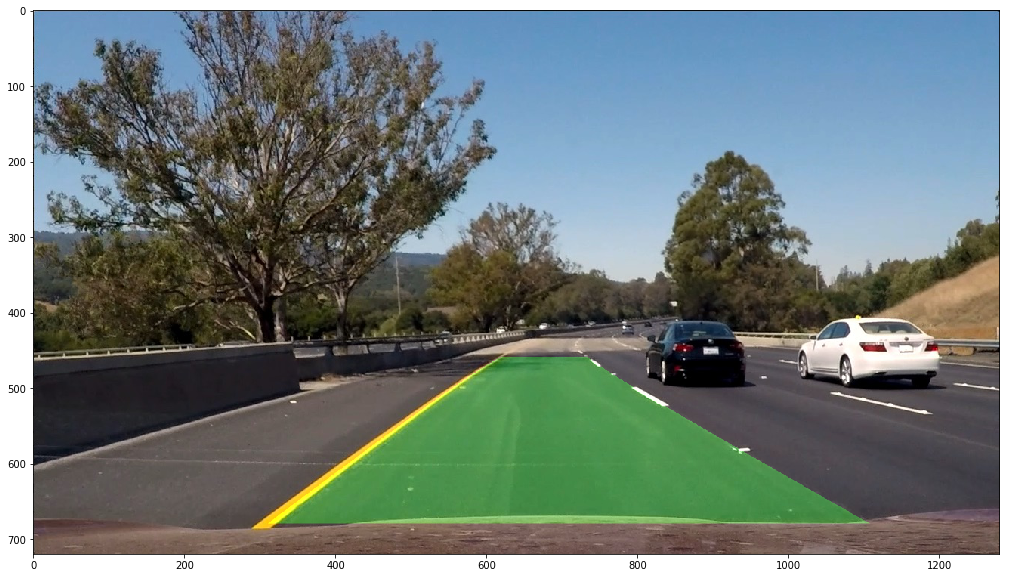

In [72]:
# Testing the Function draw_shade
shade_lane = draw_shade(img, combined_binary, left_fit, right_fit, ploty, Minv)

# Combine the result with the original, undistorted image
original_and_shade = cv2.addWeighted(img, 1, shade_lane, 0.3, 0)

# Plot the Result
plt.figure(figsize=(20,10))
plt.imshow(original_and_shade)

In [78]:
# Initialize Coeffcients for lane lines
left_fit = np.array([0,0,0])
right_fit = np.array([0,0,0])

# Pipeline for video input.output
def findlane(img):
    
    global left_fit,right_fit
    
    #make a copy of the image
    original_img = np.copy(img)
    
    # apply a distortion correction using camera matrix (mtx) and distortion coeff (dist) as inputs
    undistorted = cv2.undistort(original_img, mtx, dist, None, mtx)
    
    # apply a perspective transform
    warped, M, Minv = warp(undistorted, nx, ny, mtx, dist)

    # combine the results of each threshold function & HLS colorspace
    combined_binary = color_and_gradient_threshold(warped)
    
    # Look for lane indices
    if right_fit.any() ==0 | left_fit.any() ==0:
        # if initial values unchanged or polynomial ceases to exist use histogram to find new lane indices
        out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = find_lane_line(combined_binary, return_img=False)
    
    else:
        # If polynomial coefficiant exist from prvious run, search around them using a refined search area 
        shaded_lanes, ploty, left_fit, right_fit, left_fitx, right_fitx = search_around_poly(combined_binary, left_fit, right_fit, return_img=False)
        
    # draw green shade on detected lane and warp image back to original format   
    newwarp = draw_shade(img, combined_binary, left_fit, right_fit, ploty, Minv)
    
    # Combine the result with the original, undistorted image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    # define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    lane_centre = (left_fitx[-1] + right_fitx[-1])/2
    centre_offset_pixels = img_size[0]/2 - lane_centre
    # convert to metres from pixels using conversion
    centre_offset_metres = xm_per_pix*centre_offset_pixels
    
    # generate data points for left and right curverad
    ploty, left_fit_cr, right_fit_cr = generate_data(ploty, left_fitx, right_fitx, ym_per_pix, xm_per_pix)
    
    # define y-value where we want radius of curvature from the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5)//(2*abs(left_fit_cr[0]))  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5)//(2*abs(right_fit_cr[0]))  ## Implement the calculation of the right line here
    average_curvature = (left_curverad + right_curverad)/2*.001
    
    Curve_Radius = "Radius of Curvature - Centre of Path: " + str(float("%.2f" % average_curvature)) + " km"
    
    Offset = "Vehicle Position with Respect to Centre of Lane: "  + str(float("%.2f" % centre_offset_metres)) + " m"
    
    fontScale=1
    thickness=2
    fontFace = cv2.FONT_HERSHEY_SIMPLEX

    # Using CV2 putText to write text into images
    
    cv2.putText(result, Curve_Radius, (50,40), fontFace, fontScale,(0,255,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(result, Offset, (50,80), fontFace, fontScale,(0,255,0), thickness,  lineType = cv2.LINE_AA)
    
    return result


In [79]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [81]:
output = 'challenge_video_out.mp4'
clip1 = VideoFileClip("challenge_video.mp4")#.subclip(26,35)
test_clip = clip1.fl_image(findlane) #NOTE: this function expects color images!!
%time test_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


100%|██████████| 485/485 [01:39<00:00,  4.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

CPU times: user 49.1 s, sys: 7.57 s, total: 56.7 s
Wall time: 1min 42s
